# 1 理解大语言模型 - Large Language Model (LLM)

> 主要结构如下：
从raw data中进行预训练，得出基础模型（这一部分可以了解一下元学习的概念），这个基础模型所拥有的基础能力为文本补全、短时任务的推理能力。</br>
> 在基础模型之上，可以导入自己标记的数据进行训练，这一部分可以成为微调（finetune），得到自己的LLM，可以用于分类，总结，翻译，个人助理等任务。

![1716275709784](image/从零开始构建LLM/1716275709784.png)

> **Transformer** 结构概览</br>
1、输入需要被翻译的文本</br>
2、预处理文本</br>
3、编码器将输入文本进行编码</br>
4、将编码部分送入解码器</br>
5、模型每次只完成一个单词的翻译</br>
6、预处理文本</br>
7、解码器生成一个单词</br>
8、完成翻译</br>

![1716275687724](image/从零开始构建LLM/1716275687724.png)

> BERT与GPT区别：BERT更多的使用于文本填空，GPT则是预测下一个单词。

![1716275758151](image/从零开始构建LLM/1716275758151.png)

> **构建大模型步骤**</br>

|阶段|子项|
|---|---|
|一|准备数据和样本|
||实现注意力机制|
||实现LLM结构|
|二|训练|
||模型评估|
||加载预训练模型权重|
|三|微调自己的模型|

![1716275818354](image/从零开始构建LLM/1716275818354.png)

# 2 文本数据处理

## 2.1 词嵌入
词嵌入的根本目的是为了**将非数值数据转换为向量**，这样才能放入计算机进行运算。常见词嵌入的有**Word2Vec**。在GPT架构中，没有使用这一技术，GPT3的嵌入大小达到了12288维。其中，GPT将词嵌入作为训练模型，不断调整。也就是说，**GPT将词嵌入这一部分也进行训练**。

![1716433691383](image/从零开始构建LLM/1716433691383.png)

## 2.2 标记文本
标记文本就是将文本进行拆分，拆分为单个单词后，对每个单词进行唯一映射。可以使用字典进行标记，将每个单词映射为token id，再使用token id进行词嵌入。

In [1]:
import os
import re

In [2]:
filepath = os.path.join('data', 'the-verdict.txt')
assert os.path.exists(filepath), f"{filepath} is not exists."
with open(filepath) as f:
    raw_text = f.read()
print(">> Total number of character:", len(raw_text))
print(">> raw text:", raw_text[:100])
print()

# split raw text
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]  # remove empty string
print(">> preprocessed:", preprocessed[:30])
print(">> length:", len(preprocessed))
print()

# remove duplicate words
all_words = sorted(set(preprocessed))
vocab_size = len(all_words)
print(">> size of vocab after removed duplicate words:", vocab_size)

# create vocab
vocab = {token:integer for integer,token in enumerate(all_words)}
print(">> vocab: front 20 items")
for tok, i in vocab.items():
    if i > 20:
        break
    print(tok, i)

>> Total number of character: 20479
>> raw text: I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no g

>> preprocessed: ['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']
>> length: 4690

>> size of vocab after removed duplicate words: 1130
>> vocab: front 20 items
! 0
" 1
' 2
( 3
) 4
, 5
-- 6
. 7
: 8
; 9
? 10
A 11
Ah 12
Among 13
And 14
Are 15
Arrt 16
As 17
At 18
Be 19
Begin 20


![1716433945337](image/从零开始构建LLM/1716433945337.png)

字典表的创建方式可以通过自己创建，通过创建后的字典表，可以实现文本与token id之间的互相转换。

In [3]:
class SimpleTokenizerV1:
    def __init__(self, vocab):  # our vocab
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}  # reverse k, v
    
    def encode(self, text):  # our text
        preprocessed = re.split(r'([,.?_!"()\']|--|\s)', text)
        preprocessed = [
            item.strip() for item in preprocessed if item.strip()  # remove empty string
        ]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
        
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

tokenizer = SimpleTokenizerV1(vocab)

text = """"It's the last he painted, you know," 
           Mrs. Gisburn said with pardonable pride."""
print(">> original text: ", text)

ids = tokenizer.encode(text)
print(">> encoded data:", ids)

decoded_text = tokenizer.decode(ids)
print(">> decoded data:", decoded_text)

>> original text:  "It's the last he painted, you know," 
           Mrs. Gisburn said with pardonable pride.
>> encoded data: [1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]
>> decoded data: " It' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.


![1716434053588](image/从零开始构建LLM/1716434053588.png)

## 2.3 特殊处理
正如一般的数据预处理流程，文本中的异常数据也应当注意。当上述字典表覆盖不全面时，针对不在字典表中的字符就需要特殊处理，并且不同句子之间，也需要分割符。</br>

**为未知单词加入一些特殊标记**是非常有用的。作用如下：

* 使用特殊标记来帮助 LLM 提供额外的上下文
* 注：一些特殊标记如下<br/>
    1. [BOS] Beginning of sequence. 文本开始<br/>
    2. [EOS] end of sequence. 文本结束<br/>
    3. [PAD] padding. 使训练文本长度统一<br/>
    [UNK] 未知字符，不在字典表中<br/>
* GPT-2中仅使用`<|endoftext|>`减少复杂性，`<|endoftext|>`与`[EOS]`用法类似。GPT-2同时使用`<|endoftext|>`来进行PAD操作。
* 对于未知单词，GPT-2未使用[UNK]进行替代，而是使用字节对编码-(byte-pair encoding, BPE)将单词进行分解。

因此在上述V1版本上，我们需要进行改进，将未知字符与分割符加入字典表中：

`all_tokens.extend(["<|endoftext|>", "<|unk|>"])`

![1716455910828](image/从零开始构建LLM/1716455910828.png)

In [4]:
# preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)  # pre version
preprocessed = re.split(r'([,.?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]

all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])

vocab = {token:integer for integer,token in enumerate(all_tokens)}

vocab_size = len(vocab)
print(">> size of vocab after removed duplicate words:", vocab_size)

print(">> vocab: last 5 items")
for i, tok in enumerate(list(vocab.items())[-5:]):
    print(tok)

>> size of vocab after removed duplicate words: 1161
>> vocab: last 5 items
('younger', 1156)
('your', 1157)
('yourself', 1158)
('<|endoftext|>', 1159)
('<|unk|>', 1160)


In [5]:
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = { i:s for s,i in vocab.items()}
    
    def encode(self, text):
        preprocessed = re.split(r'([,.?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [
            item if item in self.str_to_int 
            else "<|unk|>" for item in preprocessed
        ]

        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
        
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text


tokenizer = SimpleTokenizerV2(vocab)

text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."

text = " <|endoftext|> ".join((text1, text2))

print(">> input text:", text)

ids = tokenizer.encode(text)
print(">> encoded data:", ids)

decoded_text = tokenizer.decode(ids)
print(">> decoded data:", decoded_text)

>> input text: Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.
>> encoded data: [1160, 5, 362, 1155, 642, 1000, 10, 1159, 57, 1013, 981, 1009, 738, 1013, 1160, 7]
>> decoded data: <|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.


## 2.4 字节对编码

`pip install tiktoken`


In [6]:
%pip install tiktoken
import tiktoken

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [7]:
tokenizer = tiktoken.get_encoding("gpt2")

text = "Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunknownPlace."

ids = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print(">> encoded data:", ids)

decoded_text = tokenizer.decode(ids)
print(">> decoded data:", decoded_text)

>> encoded data: [15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 286, 617, 34680, 27271, 13]
>> decoded data: Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunknownPlace.


> BPE会将未知单词拆分成独立个体的单词

![1716778401378](image/从零开始构建LLM/1716778401378.png)

## 2.5 使用滑窗进行数据采样

![1716778580547](image/从零开始构建LLM/1716778580547.png)

In [8]:
enc_text = tokenizer.encode(raw_text)
enc_sample = enc_text[50:]

context_size = 4
x = enc_sample[:context_size]
y = enc_sample[1:context_size + 1]
print(f">> x: {x}")
print(f">> y: {y}")
print()

print(">> tokenizer encode in one context:")
for i in range(1, context_size + 1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    print(f">> {context} --> {desired}")
print()

print(">> tokenizer decode in one context:")
for i in range(1, context_size + 1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    print(f">> {tokenizer.decode(context)} --> {tokenizer.decode([desired])}")

>> x: [290, 4920, 2241, 287]
>> y: [4920, 2241, 287, 257]

>> tokenizer encode in one context:
>> [290] --> 4920
>> [290, 4920] --> 2241
>> [290, 4920, 2241] --> 287
>> [290, 4920, 2241, 287] --> 257

>> tokenizer decode in one context:
>>  and -->  established
>>  and established -->  himself
>>  and established himself -->  in
>>  and established himself in -->  a


因此，我们主要关心的只有两个向量，输入和输出

![1716778596288](image/从零开始构建LLM/1716778596288.png)

In [9]:
%pip install torch

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [10]:
import torch
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(txt, batch_size=4, max_length=256, 
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=0
    )

    return dataloader

In [11]:
# modify: batch_size, max_length, stride
# will get different data
dataloader = create_dataloader_v1(
    raw_text, batch_size=2, max_length=4, stride=2, shuffle=False
)

data_iter = iter(dataloader)
data = next(data_iter)
print(f">> {data}")

>> [tensor([[  40,  367, 2885, 1464],
        [2885, 1464, 1807, 3619]]), tensor([[ 367, 2885, 1464, 1807],
        [1464, 1807, 3619,  402]])]


## 2.6 创建token嵌入

这一部分将token id转换为嵌入向量

![1716778710812](image/从零开始构建LLM/1716778710812.png)

In [12]:
# Simple Example
input_ids = torch.tensor([2, 3, 5, 1])

vocab_size = 6
output_dim = 3

torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
print(f">> {embedding_layer.weight}")

print(f">> {embedding_layer(input_ids)}")

>> Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)
>> tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)


## 2.7 编码位置向量
当token id一致时，使用同一个词嵌入会得到相同输出，如下图所示：

![1716778847577](image/从零开始构建LLM/1716778847577.png)

为了解决这一问题，引入了位置编码，这样可以保证每一个编码是独一无二的

![1716778935403](image/从零开始构建LLM/1716778935403.png)

最后，所有的数据处理流程如下：

![1716778990725](image/从零开始构建LLM/1716778990725.png)


In [13]:
vocab_size = 50257
output_dim = 256

token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

max_length = 4
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=max_length, stride=max_length, shuffle=False)

data_iter = iter(dataloader)

inputs, targets = next(data_iter)
print(f">> Token IDs:\n {inputs}")
print(f">> Inputs shape: {inputs.shape}")

token_embeddings = token_embedding_layer(inputs)
print(f">> {token_embeddings.shape}")
# >> (8, 4, 256) -> 8: batch_size, 4: max_length, 256: output_dim

context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)
pos_embeddings = pos_embedding_layer(torch.arange(context_length))
print(f">> pos embeddings's shape: {pos_embeddings.shape}")

input_embeddings = token_embeddings + pos_embeddings
print(f">> input embeddings's shape: {input_embeddings.shape}")

>> Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])
>> Inputs shape: torch.Size([8, 4])
>> torch.Size([8, 4, 256])
>> pos embeddings's shape: torch.Size([4, 256])
>> input embeddings's shape: torch.Size([8, 4, 256])


# 3 编码注意力机制

主要流程如下：
1. 一个简单的自注意力
2. LLM中使用的注意力机制
3. 因果关系的注意力机制
4. 多头注意力机制

![1716780422961](image/从零开始构建LLM/1716780422961.png)

## 3.1 长时序建模的问题

主要问题是上下文丢失。如RNN不能在解码阶段直接从编码器中访问早期的隐藏状态。因此，它只依赖于当前的隐藏状态，它封装了所有相关的信息。这可能会导致上下文的丢失，特别是在依赖关系可能跨越较长距离的复杂句子中。

## 3.2 使用注意机制捕获数据依赖关系

早期为了解决RNN对于长时序问题，研究者提出以下结构，被成为*Bahdanau attention*，这一机制使得解码阶段能够访问编码早期状态。

![1718697183686](image/从零开始构建LLM/1718697183686.png)

之后根据*Bahdanau attention*得到启发，提出了早期的*Transformer*结构。

![1716877433399](image/从零开始构建LLM/1716877433399.png)

## 3.3 自注意输入的不同部分

自注意力是LLM中Transformer的基石。
在自注意力中，“自我”是指该机制通过关联单个输入序列中的不同位置来计算注意权重的能力。它关注的是本身不同部分的关系和依赖。而传统的注意力机制则是关注两个序列之间的关系

### 3.3.1 一个简单的自我注意机制，没有训练权重

自注意的目标是为每个输入元素计算一个上下文向量，它结合了来自所有其他输入元素的信息。在自注意力中，我们的目标是为每一个输入元素${x^{(i)}}$计算上下文向量${z^{(i)}}$。一个上下文向量可以被解释为一个丰富的嵌入向量。</br>
如下图所示，*Your journey starts with one step*为输入句子，现在关注${x^{(2)}}$与${z^{(2)}}$，${z^{(2)}}$包含了从${x^{(1)}}$到${x^{(T)}}$之间的所有信息。
在自注意过程中，上下文向量起着至关重要的作用。它们的目的是通过在序列中合并来自所有其他元素的信息，在输入序列中（如句子）中创建每个元素的丰富表示，如下图所示。

![1716879045635](image/从零开始构建LLM/1716879045635.png)

![1716881565809](image/从零开始构建LLM/1716881565809.png)

In [14]:
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

query = inputs[1]  # 2nd input token is the query

attn_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query) # dot product (transpose not necessary here since they are 1-dim vectors)

print(f">> {attn_scores_2}")

>> tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


> 上述操作可以理解为矩阵的乘法 dot product，其中值越大，表示相关性越高

紧接着需要对其进行归一化操作

In [15]:
attn_scores_2 = attn_scores_2 / attn_scores_2.sum()
print(f">> attn_scores for x^2: {attn_scores_2}")
print(f">> attn_scores's sum for x^2: {attn_scores_2.sum()}")

>> attn_scores for x^2: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
>> attn_scores's sum for x^2: 1.0000001192092896


> 在实际中，更多的是使用softmax操作，这一操作在处理极值和梯度时有更好的表现。

In [16]:
def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)

attn_weights_2_naive = softmax_naive(attn_scores_2)
print(f">> attn_weights_naive for x^2: {attn_weights_2_naive}")
print(f">> attn_weights_naive's sum for x^2: {attn_weights_2_naive.sum()}")
print()

attn_weights_2 = torch.softmax(attn_scores_2, dim=0)
print(f">> attn_weights for x^2: {attn_weights_2}")
print(f">> attn_weights's sum for x^2: {attn_weights_2.sum()}")

>> attn_weights_naive for x^2: tensor([0.1630, 0.1770, 0.1765, 0.1603, 0.1570, 0.1663])
>> attn_weights_naive's sum for x^2: 1.0

>> attn_weights for x^2: tensor([0.1630, 0.1770, 0.1765, 0.1603, 0.1570, 0.1663])
>> attn_weights's sum for x^2: 1.0


In [17]:
# Above All
query = inputs[1]
context_vec_2 = torch.zeros(query.shape)
for i, x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i] * x_i
print(f">> context_vec: {context_vec_2}")

>> context_vec: tensor([0.4325, 0.5937, 0.5349])


### 3.3.2 为所有输入计算权重

![1716945187106](image/从零开始构建LLM/1716945187106.png)

计算流程与之前一致

![1716945198064](image/从零开始构建LLM/1716945198064.png)

In [18]:
# >> attention scores
# method 1
attn_scores = torch.empty(6, 6)
for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attn_scores[i, j] = torch.dot(x_i, x_j)
print(f">> attn scores: {attn_scores}")

# method 2
attn_scores = torch.matmul(inputs, inputs.T)
print(f">> attn scores: {attn_scores}")

# >> attention weights (softmax)
attn_weights = torch.softmax(attn_scores, dim=1)
print(f">> attn weights (softmax): {attn_scores}")

>> attn scores: tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])
>> attn scores: tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])
>> attn weights (softmax): tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.

## 3.4 使用训练权重实现自注意力

### 3.4.1 一步一步计算注意力权重

这里引入了三个权重${W_q}$, ${W_k}$, ${W_v}$，这三个权重矩阵用于将输入token ${x^i}$ 映射为查询，键， 值向量。

![1716947702233](image/从零开始构建LLM/1716947702233.png)

In [19]:
x_2 = inputs[1]
d_in = inputs.shape[1]
d_out = 2

# requires_grad=False to reduce clutter in the outputs for illustration purposes
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

query_2 = torch.matmul(x_2, W_query)
key_2 = torch.matmul(x_2, W_key)
value_2 = torch.matmul(x_2, W_value)

attn_scores_22 = torch.dot(query_2, key_2)
print(attn_scores_22)

tensor(1.4676)


> 权重与注意力权重的区别：</br>
权重 ${W}$ 是指神经网络中的权重，在训练过程中被优化的部分。<br/>
注意权重决定了上下文向量依赖于输入的不同部分的程度。<br/>
<br/>
总的来说，权重参数是定义神经网络的基础的、可学习的参数，而注意里权重是上下文特定的、动态的值。


In [20]:
keys = torch.matmul(inputs, W_key)
values = torch.matmul(inputs, W_value)

print(f">> keys shape: {keys.shape}")
print(f">> values shape: {values.shape}")

attn_scores_2 = torch.matmul(query_2, keys.T)

d_k = keys.shape[-1]
attn_weights_2 = torch.softmax(attn_scores_2 / d_k ** 0.5, dim=-1)
print(f">> attn weights for x_2: {attn_weights_2}")

context_vec_2 = torch.matmul(attn_weights_2, values)
print(f">> context vector for x_2: {context_vec_2}")

>> keys shape: torch.Size([6, 2])
>> values shape: torch.Size([6, 2])
>> attn weights for x_2: tensor([0.1545, 0.2136, 0.2123, 0.1320, 0.1419, 0.1457])
>> context vector for x_2: tensor([0.3341, 1.0655])


### 3.4.2 实现一个紧凑的自注意类

In [21]:
import torch.nn as nn


class SelfAttention_v1(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Parameter(torch.rand(d_in, d_out))
        self.W_key = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))
  
    def forward(self, x):
        keys = torch.matmul(x, self.W_key)
        values = torch.matmul(x, self.W_value)
        queries = torch.matmul(x, self.W_query)

        attn_scores = torch.matmul(queries, keys.T)
        attn_weights = torch.softmax(attn_scores / keys.shape[-1] ** 0.5, dim=-1)
        context_vec = torch.matmul(attn_weights, values)
        return context_vec

![1717397936262](image/从零开始构建LLM/1717397936262.png)

In [22]:
torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(f">> context: {sa_v1(inputs)}")

>> context: tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


使用 `nn.Linear` ，除了可以有效计算矩阵外，它还优化了权值初始化方案，有助于模型训练更加稳定和有效

In [23]:
class SelfAttention_v2(nn.Module):
    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
  
    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = torch.matmul(queries, keys.T)
        attn_weights = torch.softmax(attn_scores / keys.shape[-1] ** 0.5, dim=-1)
        context_vec = torch.matmul(attn_weights, values)
        return context_vec

In [24]:
torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(f">> context: {sa_v2(inputs)}")

>> context: tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


## 3.5 用因果关系的注意力来隐藏未来的词语

![1717401849186](image/从零开始构建LLM/1717401849186.png)

### 3.5.1 应用因果注意力掩码

![1717401901352](image/从零开始构建LLM/1717401901352.png)

In [25]:
queries = sa_v2.W_query(inputs)
keys = sa_v2.W_key(inputs)

attn_scores = torch.matmul(queries, keys.T)
attn_weights = torch.softmax(attn_scores / keys.shape[-1] ** 0.5, dim=-1)
print(">> attn weights:", attn_weights)

context_length = attn_scores.shape[0]
mask_simple = torch.tril(torch.ones(context_length, context_length))
print(">> mask: ", mask_simple)

masked_simple = attn_weights * mask_simple
print(">> masked: ", masked_simple)

row_sums = torch.sum(masked_simple, dim=-1, keepdim=True)
masked_simple_norm = masked_simple / row_sums
print(">> masked norm: ", masked_simple_norm)

>> attn weights: tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)
>> mask:  tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])
>> masked:  tensor([[0.1921, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2041, 0.1659, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2036, 0.1659, 0.1662, 0.0000, 0.0000, 0.0000],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.0000, 0.0000],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<MulBack

> **信息泄露**</br>
当应用掩码时，由于计算的权重已经进行了softmax，因此会有影响。然而，当我们在mask之后重新调整注意力权重时，本质是在一个更小的子集上重新计算softmax，因此mask位置对于softmax没有贡献。</br>

因此可以将流程简化为：

![1717402483387](image/从零开始构建LLM/1717402483387.png)

In [26]:
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
print(">> mask: ", mask)

masked = torch.masked_fill(attn_scores, mask.bool(), -torch.inf)
print(">> masked: ", masked)

attn_weights = torch.softmax(masked / keys.shape[-1] ** 0.5, dim=1)
print(">> attn weights: ", attn_weights)

>> mask:  tensor([[0., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0.]])
>> masked:  tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)
>> attn weights:  tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<Sof

### 3.5.2 用dropout来掩盖额外的注意权重

在transformer架构中，dropout通常用在两个地方：计算注意力分数之后或者应用注意力权重之前

![1717558177482](image/从零开始构建LLM/1717558177482.png)

需要注意的是，dropout时，会将原数值进行放大，这样能够保证注意力权重的平衡。

In [27]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5)
example = torch.ones(6, 6)
print(">> dropout rate (0.5): ", dropout(example))

print(">> dropout attn weights: ", dropout(attn_weights))

dropout = torch.nn.Dropout(0.1)
example = torch.ones(6, 6)
print(">> dropout rate (0.1): ", dropout(example))


>> dropout rate (0.5):  tensor([[2., 2., 2., 2., 2., 2.],
        [0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 2., 0.],
        [2., 2., 0., 0., 0., 2.],
        [2., 0., 0., 0., 0., 2.],
        [0., 2., 0., 0., 0., 0.]])
>> dropout attn weights:  tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4921, 0.0000, 0.4638, 0.0000, 0.0000],
        [0.0000, 0.3966, 0.3968, 0.3775, 0.3941, 0.0000],
        [0.3869, 0.3327, 0.0000, 0.0000, 0.3331, 0.3058]],
       grad_fn=<MulBackward0>)
>> dropout rate (0.1):  tensor([[1.1111, 1.1111, 1.1111, 1.1111, 1.1111, 1.1111],
        [1.1111, 1.1111, 1.1111, 1.1111, 1.1111, 0.0000],
        [0.0000, 1.1111, 1.1111, 1.1111, 1.1111, 1.1111],
        [1.1111, 1.1111, 1.1111, 0.0000, 1.1111, 1.1111],
        [1.1111, 1.1111, 0.0000, 1.1111, 1.1111, 1.1111],
        [1.1111, 1.1111, 1.1111, 1.1111, 1.1111, 1.

### 3.5.3 实现一个紧凑的因果注意力类

In [28]:
class CausalAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = torch.matmul(queries, keys.transpose(1, 2))
        attn_scores.masked_fill_(self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)
        attn_weights = torch.softmax(attn_scores / keys.shape[-1] ** 0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)
        context_vec = torch.matmul(attn_weights, values)
        return context_vec

In [29]:
batch = torch.stack((inputs, inputs), dim=0)
print(">> batch shape: ", batch.shape) # 2 inputs with 6 tokens each, and each token has embedding dimension 3

torch.manual_seed(123)

context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)

context_vecs = ca(batch)

print(">> context_vecs: ", context_vecs)
print(">> context_vecs.shape:", context_vecs.shape)

>> batch shape:  torch.Size([2, 6, 3])
>> context_vecs:  tensor([[[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]],

        [[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]]], grad_fn=<UnsafeViewBackward0>)
>> context_vecs.shape: torch.Size([2, 6, 2])


## 3.6 将单个注意力扩展到多头注意力

### 3.6.1 将多头注意力扩展到多头注意力

![1717567513041](image/从零开始构建LLM/1717567513041.png)


In [30]:
class MultiHeadAttentionWrapper(nn.Module):

    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList(
            [CausalAttention(d_in, d_out, context_length, dropout, qkv_bias) 
             for _ in range(num_heads)]
        )

    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim=-1)

In [31]:
torch.manual_seed(123)

context_length = batch.shape[1] # This is the number of tokens
d_in, d_out = 3, 2
mha = MultiHeadAttentionWrapper(
    d_in, d_out, context_length, 0.0, num_heads=2
)

context_vecs = mha(batch)

print(">> context_vecs:", context_vecs)
print(">> context_vecs.shape:", context_vecs.shape)

>> context_vecs: tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)
>> context_vecs.shape: torch.Size([2, 6, 4])


### 3.6.2 通过权重分割实现多头注意力

In [32]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False) -> None:
        super().__init__()
        assert (d_out % num_heads == 0), "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )
    
    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)

        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        attn_scores = torch.matmul(queries, keys.transpose(2, 3))

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        context_vec = torch.matmul(attn_weights, values).transpose(1, 2)

        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)

        return context_vec

![1718186662363](image/从零开始构建LLM/1718186662363.png)

In [33]:
torch.manual_seed(123)

batch_size, context_length, d_in = batch.shape
d_out = 2
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)

context_vecs = mha(batch)

print(">> context_vecs:", context_vecs)
print(">> context_vecs.shape:", context_vecs.shape)

>> context_vecs: tensor([[[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]],

        [[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]]], grad_fn=<ViewBackward0>)
>> context_vecs.shape: torch.Size([2, 6, 2])


# 4 实现GPT并生成文本

## 4.1 实现一个LLM结构

LLM总体框架图如下：
1. 词嵌入
2. 多头注意力
3. 输出层

![1718247386638](image/从零开始构建LLM/1718247386638.png)

In [34]:
# GPT-2 parameter
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

> 根据下图，一步一步编写GPT模型

![1718258629553](image/从零开始构建LLM/1718258629553.png)

编写代码如下所示，但是并没有编写归一化与具体的Transformer块。

In [35]:
class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(*[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)
  
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
  
    def forward(self, x):
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5) -> None:
        super().__init__()
  
    def forward(self, x):
        return x

> GPT数据流

![1718262314570](image/从零开始构建LLM/1718262314570.png)

In [36]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(">> batch: ", batch)

torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print(">> out shape: ", logits.shape)
print(">> out: ", logits)

>> batch:  tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
>> out shape:  torch.Size([2, 4, 50257])
>> out:  tensor([[[-1.1947,  0.1392, -0.8616,  ..., -1.4987, -0.0314, -0.4490],
         [ 0.0497,  0.3861, -0.3281,  ..., -0.1826,  1.3084,  0.9867],
         [ 0.7005,  1.4747, -0.4149,  ...,  1.7756, -0.2280,  0.5384],
         [ 0.4885,  1.7545, -0.6707,  ...,  1.1501, -0.1143, -0.9368]],

        [[-1.1947,  0.1392, -0.8616,  ..., -1.4987, -0.0314, -0.4490],
         [-0.5591,  0.5797, -0.1296,  ...,  0.2691,  0.3151,  1.4046],
         [ 0.8524,  1.2833, -0.1786,  ..., -0.1982,  0.1097,  0.2812],
         [-0.0190, -0.8277,  0.2299,  ...,  1.7974, -0.1646, -0.1049]]],
       grad_fn=<UnsafeViewBackward0>)


## 4.2 使用layer normalization进行归一化激活

> 由于梯度消失或爆炸等问题，训练多层深度神经网络有时会具有挑战性。这些问题导致了不稳定的训练动态，使网络难以有效地调整其权值，这意味着学习过程很难为神经网络找到一组参数（权值），以最小化损失函数。换句话说，该网络很难学习数据中的潜在模式，其程度将使其能够做出准确的预测或决策。</br>

> 层归一化背后的主要思想是调整神经网络层的激活（输出），使其均值为0，方差为1，也称为单位方差。这种调整加速了收敛到有效的权重，并确保了一致、可靠的训练。</br>

> **层归一化通常在多头注意模块前后和最终输出层之前应用。**

In [37]:
# torch.set_printoptions(sci_mode=True)  # set float number

class LayerNorm(nn.Module):
    def __init__(self, emb_dim) -> None:
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
  
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

## 4.3 使用层归一化实现前向神经网络

**GeLU**激活函数

在神经网络中，使用最广泛的是ReLU函数，但是在LLM，除了ReLU外，还有两种显著的激活函数：GELU (Gaussian Error Linear Unit) 和 SwiGLU (Sigmoid-Weighted Linear Unit)。GELU和SwiGLU分别是更复杂和光滑的包含高斯单元和s型门控线性单位的激活函数。他们可以表现的更好。

$$
\text{GELU}(x) \approx 0.5 \cdot x \cdot \left(1 + \tanh\left[\sqrt{\frac{2}{\pi}} \cdot \left(x + 0.044715 \cdot x^3\right)\right]\right)
$$

In [38]:
class GELU(nn.Module):
    def __init__(self) -> None:
        super().__init__()
    
    def forward(self, x):
        return 0.5 * x * ( 1 + torch.tanh(torch.sqrt(torch.tensor(2 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))

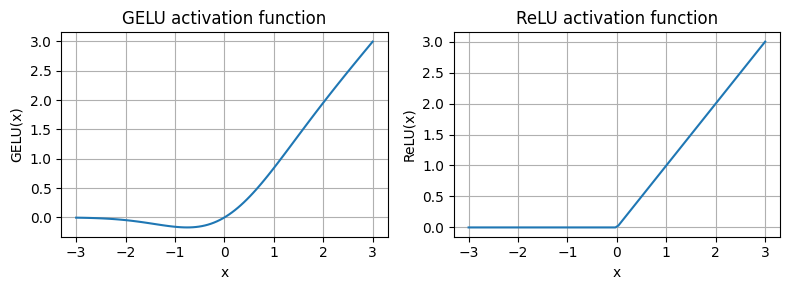

In [39]:
# GELU Test
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ['GELU', "ReLU"])):
    plt.subplot(1, 2, i+1)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel('x')
    plt.ylabel(f"{label}(x)")
    plt.grid()
plt.tight_layout()

> 在此基础上实现一个前馈网络，这个前馈网络至关重要，主要解决非线性问题，并且可以探索更丰富的空间。

In [40]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"])
        )
    
    def forward(self, x):
        return self.layer(x)

In [41]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)
out = ffn(x)
print(">> ffn out size: ", out.shape)

>> ffn out size:  torch.Size([2, 3, 768])


## 4.4 增加短连接

short connection通过跳过一个或多个层来创建一个梯度通过网络的更短路径，这是通过将一个层的输出添加到后面一个层的输出来实现的。这就是为什么这些连接也被称为跳过连接。在训练过程中，它们在保持梯度的流动方面起着至关重要的作用。

![1718273582034](image/从零开始构建LLM/1718273582034.png)

In [42]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut) -> None:
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU()),
        ])
    
    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

In [43]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
model_without_shorcut = ExampleDeepNeuralNetwork(layer_sizes, False)

def print_gradients(model, x):
    output = model(x)
    target = torch.tensor([[0.]])

    loss = nn.MSELoss()
    loss = loss(output, target)
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f">> {name} has gradient mean of {param.grad.abs()}")

In [44]:
print_gradients(model_without_shorcut, sample_input)

>> layers.0.0.weight has gradient mean of tensor([[0.0018, 0.0000, 0.0018],
        [0.0010, 0.0000, 0.0010],
        [0.0065, 0.0000, 0.0065]])
>> layers.1.0.weight has gradient mean of tensor([[6.3482e-07, 3.8762e-07, 7.6243e-06],
        [1.5987e-04, 9.7618e-05, 1.9201e-03],
        [8.4790e-05, 5.1773e-05, 1.0183e-03]])
>> layers.2.0.weight has gradient mean of tensor([[0.0039, 0.0031, 0.0015],
        [0.0041, 0.0033, 0.0015],
        [0.0050, 0.0040, 0.0019]])
>> layers.3.0.weight has gradient mean of tensor([[0.0491, 0.0031, 0.0283],
        [0.0257, 0.0016, 0.0148],
        [0.0465, 0.0029, 0.0268]])
>> layers.4.0.weight has gradient mean of tensor([[0.0417, 0.0856, 0.0110]])


In [45]:
model_without_shorcut = ExampleDeepNeuralNetwork(layer_sizes, True)
print_gradients(model_without_shorcut, sample_input)

>> layers.0.0.weight has gradient mean of tensor([[3.2044e-06, 0.0000e+00, 3.2044e-06],
        [1.8830e-03, 0.0000e+00, 1.8830e-03],
        [3.0898e-03, 0.0000e+00, 3.0898e-03]])
>> layers.1.0.weight has gradient mean of tensor([[1.5119e-04, 1.8919e-05, 1.4878e-04],
        [8.6263e-04, 1.0795e-04, 8.4891e-04],
        [2.0144e-04, 2.5207e-05, 1.9824e-04]])
>> layers.2.0.weight has gradient mean of tensor([[2.1789e-04, 6.5373e-06, 2.5559e-04],
        [1.2170e-03, 3.6514e-05, 1.4276e-03],
        [4.6673e-05, 1.4003e-06, 5.4749e-05]])
>> layers.3.0.weight has gradient mean of tensor([[1.8056e-04, 2.5326e-05, 2.2459e-04],
        [3.3904e-03, 4.7555e-04, 4.2170e-03],
        [1.9221e-03, 2.6960e-04, 2.3907e-03]])
>> layers.4.0.weight has gradient mean of tensor([[0.0184, 0.0108, 0.0193]])


## 4.5 连接注意力层和线性层

**transformer block的说明**

![1718347509428](image/从零开始构建LLM/1718347509428.png)

In [46]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg) -> None:
        super().__init__()
        self.att = MultiHeadAttention(d_in=cfg["emb_dim"], 
                                      d_out=cfg["emb_dim"],
                                      context_length=cfg["context_length"], 
                                      num_heads=cfg["n_heads"],
                                      dropout=cfg["drop_rate"],
                                      qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_resid = nn.Dropout(cfg["drop_rate"])
    
    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_resid(x)
        x = x + shortcut

        shortcut = x

        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_resid(x)
        x = x + shortcut
        return x

## 4.6 编码GPT模型

![1718352064601](image/从零开始构建LLM/1718352064601.png)

In [47]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [48]:
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print(">> input batch: ", batch)
print(">> output shape: ", out.shape)
print(">> out: ", out)

>> input batch:  tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
>> output shape:  torch.Size([2, 4, 50257])
>> out:  tensor([[[ 0.2159,  1.7803, -1.3144,  ...,  0.1518,  0.3433, -0.2426],
         [-0.4640,  0.0124, -0.0818,  ...,  0.1752,  0.8148,  0.2054],
         [-0.3823,  0.1988,  0.2054,  ...,  0.0659, -0.1415,  0.1057],
         [-0.1542,  0.7591, -0.2797,  ..., -0.2908,  0.6896, -0.1746]],

        [[-0.2024,  1.6316, -0.9047,  ...,  0.1310,  0.5152, -0.3395],
         [-0.0648,  0.8608, -0.4911,  ...,  0.5268, -0.0134,  0.3010],
         [-0.1856, -0.6939,  0.0868,  ...,  0.5741, -0.0706,  0.2637],
         [-0.0827, -0.1011,  0.4543,  ...,  0.1231, -0.1420,  0.0325]]],
       grad_fn=<UnsafeViewBackward0>)


In [49]:
total_params = sum(p.numel() for p in model.parameters())
print(f">> total number of parameters: {total_params}")


>> total number of parameters: 163009536


> 之前提到代码参数工1.24亿，但是为何这里输出为1.63亿呢？<br/>
其原因是在原始的GPT-2体系结构中使用了一个称为**权重绑定**的概念，这意味着原始的GPT-2体系结构在其输出层中重用了来自标记嵌入层的权重。为了理解这意味着什么，来看看我们之前通过GPTModel在模型上初始化的令牌嵌入层和线性输出层的形状：

In [50]:
print(f">> Token embedding layer shape: {model.tok_emb.weight.shape}")
print(f">> Output layer shape: {model.out_head.weight.shape}")

>> Token embedding layer shape: torch.Size([50257, 768])
>> Output layer shape: torch.Size([50257, 768])


> 由于字典表的大小为50257，这导致嵌入层非常大。且输出层重用了嵌入层的权重，因此应减去这一部分的参数。

> 在一般情况下，不是用权重绑定。

In [51]:
total_params_gpt2 = total_params - sum(p.numel() for p in model.out_head.parameters())
print(f">> Number of trainable parameters considering weight tying: {total_params_gpt2}")

>> Number of trainable parameters considering weight tying: 124412160


In [52]:
total_size_bytes = total_params * 4
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


## 4.7 生成文本

![1718358855510](image/从零开始构建LLM/1718358855510.png)

![1718358887750](image/从零开始构建LLM/1718358887750.png)


In [53]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=-1)
    return idx

In [54]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print(">> encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print(">> encoded_tensor.shape:", encoded_tensor.shape)

>> encoded: [15496, 11, 314, 716]
>> encoded_tensor.shape: torch.Size([1, 4])


In [58]:
model.eval()
out = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"]
)
print(">> Output:", out)
print(">> Output length:", len(out[0]))

>> Output: tensor([[15496,    11,   314,   716, 17480, 23268,  2497, 19749,  1333, 15262]])
>> Output length: 10


In [59]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(">> Generated text: ", decoded_text)

>> Generated text:  Hello, I amINGTON vow saw bourgeois triBay


# 5 在未标记的数据上进行训练

## 5.1 评估生成文本模型

![1718851702204](image/从零开始构建LLM/1718851702204.png)

5.1.1 使用GPT模型生成文本


In [83]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256, #A
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1, #B
    "qkv_bias": False
}
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layer): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768

与之前的进行对比，context_length减少到256（之前为1024），这一改变减少了计算需求，使得能够在桌面版计算机上运行。
在之后的训练中，将其更新回1024，以便于加载预训练模型。

---

三步生成文本的过程：
1. tokenizer将输入文本转换为一系列token IDs
2. 模型将token IDs转换为对应的logits，logits表示每个token在字典中可能的分布状况
3. 将logits转换为token IDs，tokenizer再进行解码，生成文本

![1718853446792](image/从零开始构建LLM/1718853446792.png)

In [61]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    decoded = tokenizer.decode(token_ids.squeeze(0).tolist())
    return decoded

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

encoded = text_to_token_ids(start_context, tokenizer)
print(">> encoded:", encoded)

token_ids = generate_text_simple(model=model, idx=encoded, max_new_tokens=10, context_size=GPT_CONFIG_124M['context_length'])

decoded_text = token_ids_to_text(token_ids, tokenizer)
print(">> decoded_text:", decoded_text)

>> encoded: tensor([[6109, 3626, 6100,  345]])
>> decoded_text: Every effort moves you tier dwell Emperor frequent glacierCV SaberTheme number stuffed


### 5.1.2 计算文本生成的损失

![1718854323771](image/从零开始构建LLM/1718854323771.png)

In [62]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1)
print(">> probas: ", probas)

token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print(">> token_ids: ", token_ids)

print(">> target batch: ", token_ids_to_text(targets[0], tokenizer))
print(">> predicted batch: ", token_ids_to_text(token_ids[0].flatten(), tokenizer))

>> probas:  tensor([[[9.6198e-06, 2.4149e-05, 8.7226e-06,  ..., 3.6962e-05,
          1.0996e-05, 2.2752e-05],
         [4.5642e-06, 1.3964e-05, 2.1854e-05,  ..., 3.4952e-05,
          2.3353e-05, 3.5968e-05],
         [8.8770e-06, 1.1363e-05, 1.5514e-05,  ..., 2.9990e-05,
          1.1737e-05, 2.2775e-05]],

        [[7.2513e-06, 2.1858e-05, 1.6114e-05,  ..., 4.5776e-05,
          2.5422e-05, 4.1621e-05],
         [3.7363e-06, 1.7486e-05, 2.5110e-05,  ..., 2.4692e-05,
          2.0825e-05, 4.5605e-05],
         [2.2280e-05, 9.2259e-06, 2.2976e-05,  ..., 1.6067e-05,
          1.4410e-05, 2.5571e-05]]])
>> token_ids:  tensor([[[21158],
         [15863],
         [ 1482]],

        [[26478],
         [14290],
         [50105]]])
>> target batch:   effort moves you
>> predicted batch:   slam donated Con


由于还未被训练，因此产生的为随机文本。
训练过程是不断减小目标与预测值之间的“距离”。

![1718868480909](image/从零开始构建LLM/1718868480909.png)

In [69]:
# 2-3
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print(">> Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print(">> Text 2:", target_probas_2)

# 4
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(">> log probas: ", log_probas)

# 5
avg_log_probas = torch.mean(log_probas)
print(">> avg log probas: ", avg_log_probas)

# 6
neg_avg_log_probas = -avg_log_probas
print(">> neg avg log probas: ", neg_avg_log_probas)

>> Text 1: tensor([1.2231e-05, 1.0606e-05, 2.6981e-05])
>> Text 2: tensor([9.0465e-06, 2.4282e-05, 2.5903e-05])
>> log probas:  tensor([-11.3115, -11.4541, -10.5204, -11.6131, -10.6258, -10.5612])
>> avg log probas:  tensor(-11.0144)
>> neg avg log probas:  tensor(11.0144)


交叉熵 Cross Entropy Loss， 是用来衡量两个概率分布之间的差异

In [72]:
# Logits have shape (batch_size, num_tokens, vocab_size)
print(">> Logits shape:", logits.shape)

# Targets have shape (batch_size, num_tokens)
print(">> Targets shape:", targets.shape)

>> Logits shape: torch.Size([2, 3, 50257])
>> Targets shape: torch.Size([2, 3])


在进行交叉熵之前，需要检查向量维度

In [73]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print(">> Flattened logits:", logits_flat.shape)
print(">> Flattened targets:", targets_flat.shape)

>> Flattened logits: torch.Size([6, 50257])
>> Flattened targets: torch.Size([6])


In [74]:
loss = nn.functional.cross_entropy(logits_flat, targets_flat)
print(">> Loss: ", loss)

>> Loss:  tensor(11.0144)


> 困惑度</br>

困惑度也是评价语言模型好坏的指标。它可以提供一种更可解释的方法来理解模型在预测序列中的下一个标记时的不确定性。</br>
困惑度衡量了模型预测的概率分布与数据集中单词的实际分布的匹配程度。与损失相似，较低的困惑度表明模型的预测更接近实际分布。</br>
困惑度的可解释性在于它表示模型在每一步中都不确定的有效词汇表大小。</br>

In [75]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(60739.7578)


### 5.1.3 计算训练和验证损失

In [77]:
text_data = raw_text
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print(">> Characters:", total_characters)
print(">> Tokens:", total_tokens)

>> Characters: 20479
>> Tokens: 5145


![1718868663879](image/从零开始构建LLM/1718868663879.png)

In [80]:
train_ratio = 0.9
split_idx = int(len(text_data) * train_ratio)
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [85]:
train_loader = create_dataloader_v1(train_data, 
                                    batch_size=2, 
                                    max_length=GPT_CONFIG_124M['context_length'], 
                                    stride=GPT_CONFIG_124M['context_length'], 
                                    drop_last=True, 
                                    shuffle=True)
val_loader = create_dataloader_v1(val_data, 
                                  batch_size=2, 
                                  max_length=GPT_CONFIG_124M['context_length'], 
                                  stride=GPT_CONFIG_124M['context_length'], 
                                  drop_last=False, 
                                  shuffle=False)

In [86]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [87]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(len(data_loader), num_batches)
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i >= num_batches:
            break
        loss = calc_loss_batch(input_batch, target_batch, model, device)
        total_loss += loss.item()
    return total_loss / num_batches

In [88]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
train_loss = calc_loss_loader(train_loader, model, device)
print(f">> Train loss: {train_loss}")

val_loss = calc_loss_loader(val_loader, model, device)
print(f">> Val loss: {val_loss}")

>> Train loss: 10.989679866366917
>> Val loss: 11.008943557739258


## 5.2 训练一个LLM

![1718875144870](image/从零开始构建LLM/1718875144870.png)

In [92]:
def evaluete_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    excoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(model, excoded, 50 , context_size)
        decoded_text = token_ids_to_text(token_ids, tokenizer)
        print(f">> {start_context} --> {decoded_text}")
    model.train()


def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_token_seen = [], [], []
    token_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            token_seen += input_batch.numel()
            global_step += 1
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluete_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_token_seen.append(token_seen)
                print(f">> Epoch {epoch + 1}, step {global_step: 06d}: train loss {train_loss:.4f}, val loss {val_loss:.4f}")
    
        generate_and_print_sample(model, tokenizer, device, start_context)
    return train_losses, val_losses, track_token_seen

In [93]:
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=4e-4, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, track_token_seen = train_model_simple(model, train_loader, val_loader, optimizer, device,
                                                               num_epochs, 5, 5, "Every effort moves you", tokenizer)

>> Epoch 1, step  00000: train loss 10.7070, val loss 10.7820
>> Epoch 1, step  00005: train loss 9.5462, val loss 9.7495
>> Every effort moves you --> Every effort moves you,,,















































>> Epoch 2, step  00010: train loss 8.9008, val loss 9.1415
>> Epoch 2, step  00015: train loss 8.4460, val loss 8.6694
>> Every effort moves you --> Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,.















>> Epoch 3, step  00020: train loss 8.0585, val loss 8.2633
>> Epoch 3, step  00025: train loss 7.6819, val loss 7.9278
>> Every effort moves you --> Every effort moves you,,,















































>> Epoch 4, step  00030: train loss 7.4977, val loss 7.6869
>> Epoch 4, step  00035: train loss 7.2686, val loss 7.5326
>> Every effort moves you --> Every effort moves you,,,,,,,,,,,,,,, the the the,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
>> Epoch 5, step  00040: train loss 7.1630, val loss 7.4220
>> Every effort moves you --> Every e

In [100]:
# save model
torch.save(model.state_dict(), "model.pt")

# load model
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pt"))
model.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layer): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768

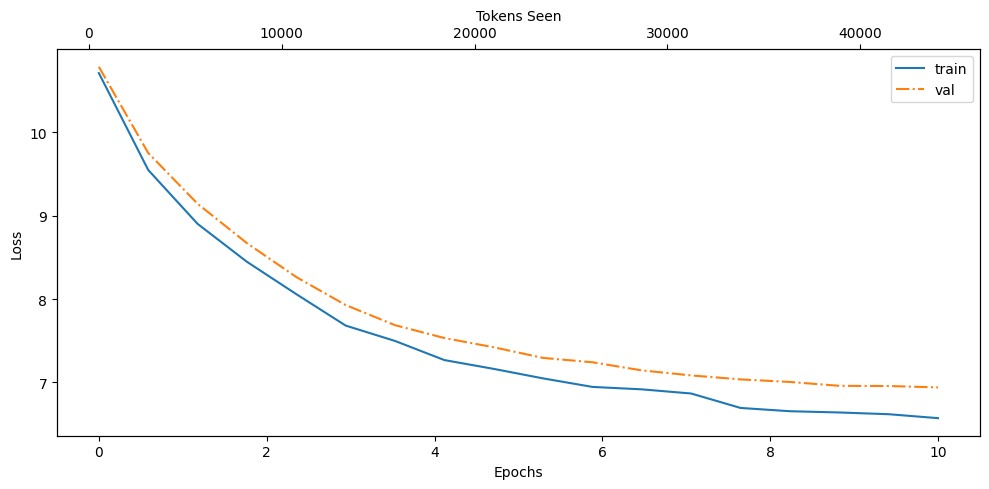

In [101]:
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax = plt.subplots(figsize=(10, 5))

    ax.plot(epochs_seen, train_losses, label="train")
    ax.plot(epochs_seen, val_losses, linestyle='-.', label="val")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.legend()

    ax1 = ax.twiny()
    ax1.plot(tokens_seen, train_losses, alpha=0)
    ax1.set_xlabel("Tokens Seen")

    fig.tight_layout()
    plt.show()

epoch_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epoch_tensor, track_token_seen, train_losses, val_losses)

## 5.3 控制随机性的解码策略

主要介绍两个函数：`temperature scaling` 和 `top-k sampling`

首先需要将模型转到cpu上，因为较小的模型在推理时不需要gpu

In [102]:
model.to('cpu')
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layer): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768

In [104]:
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(model=model,
                                 idx=text_to_token_ids("Every effort moves you", tokenizer),
                                 max_new_tokens=25,
                                 context_size=GPT_CONFIG_124M["context_length"])
print(">> generated text: ", token_ids_to_text(token_ids, tokenizer))

>> generated text:  Every effort moves you, and, and, I, and.


















### 5.3.1 Temperature scaling

一种向下一代标记生成任务添加概率选择过程的技术。